<a href="https://colab.research.google.com/github/cmccomb/TrussMe/blob/main/examples/optimizing_for_mass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install TrussMe

In [1]:
!pip install git+https://github.com/cmccomb/trussme.git -qqq

  Preparing metadata (setup.py) ... done


# Set up functions for optimization

In [2]:
import trussme
import scipy.optimize
import numpy

First, let's construct a truss that we will use as a starting point.

In [3]:
truss_from_commands = trussme.Truss()
truss_from_commands.add_pinned_joint([0.0, 0.0, 0.0])
truss_from_commands.add_free_joint([1.0, 0.0, 0.0])
truss_from_commands.add_free_joint([2.0, 0.0, 0.0])
truss_from_commands.add_free_joint([3.0, 0.0, 0.0])
truss_from_commands.add_free_joint([4.0, 0.0, 0.0])
truss_from_commands.add_pinned_joint([5.0, 0.0, 0.0])

truss_from_commands.add_free_joint([0.5, 1.0, 0.0])
truss_from_commands.add_free_joint([1.5, 1.0, 0.0])
truss_from_commands.add_free_joint([2.5, 1.0, 0.0])
truss_from_commands.add_free_joint([3.5, 1.0, 0.0])
truss_from_commands.add_free_joint([4.5, 1.0, 0.0])

truss_from_commands.add_out_of_plane_support("z")

truss_from_commands.joints[8].loads[1] = -20000

truss_from_commands.add_member(0, 1)
truss_from_commands.add_member(1, 2)
truss_from_commands.add_member(2, 3)
truss_from_commands.add_member(3, 4)
truss_from_commands.add_member(4, 5)

truss_from_commands.add_member(6, 7)
truss_from_commands.add_member(7, 8)
truss_from_commands.add_member(8, 9)
truss_from_commands.add_member(9, 10)

truss_from_commands.add_member(0, 6)
truss_from_commands.add_member(6, 1)
truss_from_commands.add_member(1, 7)
truss_from_commands.add_member(7, 2)
truss_from_commands.add_member(2, 8)
truss_from_commands.add_member(8, 3)
truss_from_commands.add_member(3, 9)
truss_from_commands.add_member(9, 4)
truss_from_commands.add_member(4, 10)
truss_from_commands.add_member(10, 5)

In [4]:
goals = trussme.Goals(
    minimum_fos_buckling = 1.0,
    minimum_fos_yielding = 1.0,
    maximum_deflection = 0.01
)

mass = 37.58 kg;  FOS = 2.95;  deflection = 0.28 cm; 


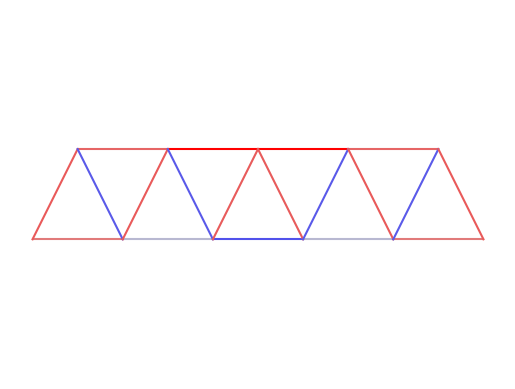

In [5]:
truss_from_commands.analyze()
print(
    "mass = {:.2f} kg; ".format(truss_from_commands.mass),
    "FOS = {:.2f}; ".format(truss_from_commands.fos),
    "deflection = {:.2f} cm; ".format(truss_from_commands.deflection*100)
)
trussme.visualize.plot_truss(truss_from_commands, starting_shape="force");

# Mass Minimization by Joint Coordinates
Next, let's generate a mass-minimal truss by moving the joints around only

In [6]:
x0, objective, constraints, generate_truss, bounds = trussme.make_optimization_functions(truss_from_commands, goals, joint_coordinates=True, shape_parameters=False)

In [7]:
results = scipy.optimize.minimize(
    objective,
    x0,
    constraints=scipy.optimize.NonlinearConstraint(constraints, -numpy.inf, 0.0, keep_feasible=True),
    bounds=scipy.optimize.Bounds(bounds[0], bounds[1], keep_feasible=True),
    method='trust-constr',
    options={
        "verbose": 2,
        "maxiter": 100,
    }
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |  17   |   0   | +3.7583e+01 | 1.00e+00 | 3.32e+00 | 0.00e+00 |
|   2   |  34   |   1   | +2.9515e+01 | 7.00e+00 | 2.97e+00 | 0.00e+00 |
|   3   |  51   |   7   | +2.9515e+01 | 1.72e+00 | 2.97e+00 | 0.00e+00 |
|   4   |  68   |  13   | +2.9515e+01 | 1.72e-01 | 2.97e+00 | 0.00e+00 |
|   5   |  85   |  15   | +2.8458e+01 | 1.20e+00 | 2.67e+00 | 0.00e+00 |
|   6   |  102  |  24   | +2.8458e+01 | 1.20e-01 | 2.67e+00 | 0.00e+00 |
|   7   |  119  |  26   | +2.7795e+01 | 8.41e-01 | 2.27e+00 | 0.00e+00 |
|   8   |  136  |  35   | +2.7795e+01 | 8.41e-02 | 2.27e+00 | 0.00e+00 |
|   9   |  153  |  38   | +2.7531e+01 | 5.89e-01 | 2.12e+00 | 0.00e+00 |
|  10   |  170  |  49   | +2.6950e+01 | 3.37e+00 | 2.77e+00 | 0.00e+00 |
|  11   |  187  |  61   | +2.6732e+01 | 3.37e+00 | 3.20e+00 | 0.00e+00 |
|  12   |  204  |  66   | +2.6572e+01 | 3.37e+00 | 

mass = 21.13 kg;  FOS = 1.04;  deflection = 0.58 cm; 


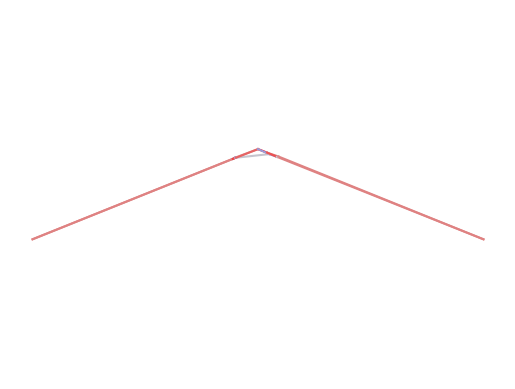

In [8]:
optimal_truss = generate_truss(results.x)
optimal_truss.analyze()
print(
    "mass = {:.2f} kg; ".format(optimal_truss.mass),
    "FOS = {:.2f}; ".format(optimal_truss.fos),
    "deflection = {:.2f} cm; ".format(optimal_truss.deflection*100)
)
trussme.visualize.plot_truss(optimal_truss, starting_shape="force");

# Mass Minimal by Joint Coordinates and Cross-Sections
Next, let's generate a mass-minimal truss by moving the joints around and updating cross-section size

In [9]:
x0, objective, constraints, generate_truss, bounds = trussme.make_optimization_functions(truss_from_commands, goals, joint_coordinates=True, shape_parameters=True)

In [12]:
results = scipy.optimize.minimize(
    objective,
    x0,
    constraints=scipy.optimize.NonlinearConstraint(constraints, -numpy.inf, 0.0, keep_feasible=True),
    bounds=scipy.optimize.Bounds(bounds[0], bounds[1], keep_feasible=True),
    method='trust-constr',
    options={
        "verbose": 2,
        "maxiter": 100,
    }
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |  36   |   0   | +3.7583e+01 | 1.00e+00 | 3.49e+00 | 0.00e+00 |
|   2   |  72   |   1   | +2.1379e+01 | 2.00e+00 | 2.06e+00 | 0.00e+00 |
|   3   |  108  |  11   | +2.1379e+01 | 2.00e-01 | 2.06e+00 | 0.00e+00 |
|   4   |  144  |  13   | +1.9409e+01 | 1.40e+00 | 1.88e+00 | 0.00e+00 |
|   5   |  180  |  23   | +1.9409e+01 | 1.40e-01 | 1.88e+00 | 0.00e+00 |
|   6   |  216  |  26   | +1.8174e+01 | 9.80e-01 | 1.77e+00 | 0.00e+00 |
|   7   |  252  |  32   | +1.8174e+01 | 9.80e-02 | 1.77e+00 | 0.00e+00 |
|   8   |  288  |  35   | +1.7375e+01 | 6.86e-01 | 1.69e+00 | 0.00e+00 |
|   9   |  324  |  38   | +1.7375e+01 | 6.86e-02 | 1.69e+00 | 0.00e+00 |
|  10   |  360  |  41   | +1.6846e+01 | 4.80e-01 | 1.91e+00 | 0.00e+00 |
|  11   |  396  |  45   | +1.6846e+01 | 4.80e-02 | 1.91e+00 | 0.00e+00 |
|  12   |  432  |  48   | +1.6490e+01 | 3.36e-01 | 

mass = 12.69 kg;  FOS = 1.00;  deflection = 0.54 cm; 


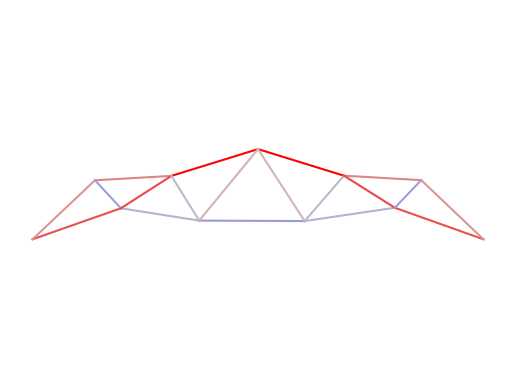

In [13]:
optimal_truss = generate_truss(results.x)
optimal_truss.analyze()
print(
    "mass = {:.2f} kg; ".format(optimal_truss.mass),
    "FOS = {:.2f}; ".format(optimal_truss.fos),
    "deflection = {:.2f} cm; ".format(optimal_truss.deflection*100)
)
trussme.visualize.plot_truss(optimal_truss, starting_shape="force");